In [1]:
import numpy as np
import pickle as pkl
import csv
import re

In [43]:
# tp_path = "../../data/HCCdryad/Dryad_English_train.csv"
# patient_pre = "Deri_Patient"
path_and_pre = {"train":("../../data/HCCdryad/Dryad_English_train.csv", "Deri_Patient"),
               "valid":("../../data/HCCdryad/Dryad_English_validation.csv", "Inter_Patient"),
               "test":("../../data/HCCdryad/Dryad_English_test.csv", "MultiCentre_Patient")}
tp_set = "train"
tp_path = path_and_pre[tp_set][0]
patient_pre = path_and_pre[tp_set][1]

val_dict_all = {"train":{"Cause and type of Hepatitis":[1,2,3], 
                         "Treatment Response in last Time slice": [1,2,3],
                         "Location of Lesions":[1,2,3,4],
                         "Branch of invaded portal vein ":[1,2,3,4,5],
                        "Invasion of hepatic veins":[1,2,3], 
                         "Invasion of Vena Canva or Atrium":[1,2,3], 
                         "Ascites":[1,2,3,4]
               },
                         
               "valid":{"Location of Lesions":[1,2,3,4],
                         "Branch of invaded portal vein ":[1,2,3,4,5],
                        "Invasion of hepatic veins":[1,2,3], 
                         "Invasion of Vena Canva or Atrium":[1,2,3], 
                         "Ascites":[1,2,3,4]
               },
                "test":{"Location of Lesions":[1,2,3,4],
                         "Branch of invaded portal vein ":[1,2,3,4,5],
                        "Invasion of hepatic veins":[1,2,3], 
                         "Invasion of Vena Canva or Atrium":[1,2,3], 
                         "Ascites":[1,2,3,4]
               },
               } # some columns have multiple values. Use one-hot encoding for them

# WARNING: this is the modified training set
# modified training data is the dataset where the columns of training is the same as testing and validation
val_dict = val_dict_all["test"] 

with open(tp_path, "r", encoding='cp932') as f:
    contents = csv.reader(f, delimiter=",")
    data_all = {} # each data point is a tuple (X, y)
    
    # current data
    for tp_row in contents:
        if tp_row[0][:len(patient_pre)] == patient_pre:
            tp_id = int(tp_row[tp_col_names["ID_No"]][len(patient_pre):])

            if tp_id not in data_all:
                data_all[tp_id] = [[[], [],[]], 0] # time, values, if measured

            tp_tms = data_all[tp_id][0][0] # time of measurement after the admission
            tp_vals = [] # value of each measurement
            tp_meas = data_all[tp_id][0][2] # if values are measured
            tp_length = 0 # survival time after the last measurement

            # extraction of data
            tp_time = float(tp_row[tp_col_names["Cummulated Time since first admission (months)"]]) # time of measurement after the first admission (month)
            tp_tms.append(tp_time)
            death_or_not = int(tp_row[tp_col_names["Death"]]) # death=1, live=0
            tp_surv_time = float(tp_row[tp_col_names["Overall Survival Time (months)"]]) # survival or censoring time

            if death_or_not == 1:
                tp_length = -tp_surv_time
            elif death_or_not == 0:
                tp_length = tp_surv_time

            tt_vals = [tp_row[i] for i in val_index if tp_get_col_name[i] not in val_dict] # simple values
            tp_vals.extend([float(tv.strip("Y")) if len(tv)>0 else np.nan for tv in tt_vals]) # values without one-hot encoding

            tt_vals_comp_onehot = {i:[0]*len(val_dict[i]) for i in val_dict} # one-hot encoding
            for tp_name in val_dict:
                tp_s = tp_row[tp_col_names[tp_name]]
                if len(tp_s)>0:
                    tp_types = [tt_s for tt_s in tp_s]
                    tp_types = {int(tt_s) for tt_s in tp_types if tt_s.isdigit()}
                    for j in range(len(val_dict[tp_name])):
                        if val_dict[tp_name][j] in tp_types:
                            tt_vals_comp_onehot[tp_name][j] = 1

                else:
                    tt_vals_comp_onehot[tp_col_names[tp_name]] = [np.nan] * len(val_dict[tp_name])

                tp_vals.extend(tt_vals_comp_onehot[tp_name])
            data_all[tp_id][0][1].append(tp_vals)
            tp_meas.append([True if np.isnan(tv)==False else False for tv in tp_vals])

            data_all[tp_id][1] = tp_length
        else:
            tp_col_names = {tp_row[i]:i for i in range(len(tp_row))}
            tp_get_col_name = {i:tp_row[i] for i in range(len(tp_row))}
            
            # index of values # WARNING: this is the modified training set
            val_index = [tp_col_names[tp_name] for tp_name in test_col if tp_name[-2]!="T"] #[tp_col_names["Age (years)"], tp_col_names["Gender"]] + list(range(tp_col_names["Overall Survival Time (months)"]+1, len(tp_row)-1))
            
            
for tp_id in data_all:
    data_all[tp_id] = ([np.array(tp_x) for tp_x in data_all[tp_id][0]], data_all[tp_id][1])
    
colums = [tp_get_col_name[i] for i in val_index if tp_get_col_name[i] not in val_dict]
for tp_name in val_dict:
    for tp_index in val_dict[tp_name]:
        colums.append(tp_name + " T"+str(tp_index))
        
# save data
with open("../../data/HCCdryad/pickle/HCCdryad_"+tp_set+"_modified_train.pkl", 'wb') as f:
    pkl.dump((data_all, colums), f)

In [2]:
with open("../../data/HCCdryad/pickle/HCCdryad_train_modified_train.pkl", 'rb') as f:
    train_data, train_col = pkl.load(f)
    
with open("../../data/HCCdryad/pickle/HCCdryad_valid.pkl", 'rb') as f:
    valid_data, valid_col = pkl.load(f)
    
with open("../../data/HCCdryad/pickle/HCCdryad_test.pkl", 'rb') as f:
    test_data, test_col = pkl.load(f)

In [3]:
for i in range(len(train_col)):
    print(train_col[i]==valid_col[i])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [28]:
# process data
def get_Xy(current_data, tp_cols):
    num_var = len(tp_cols)
    tp_X = []
    tp_y = []
    for i in current_data:
        tp_vals = current_data[i][0][1]
        tp_meas = current_data[i][0][2]
        
        tp_data = [np.nan]*(num_var)
        for j in range(num_var):
            tp_true_index = np.where(tp_meas[:, j])[0]
            if len(tp_true_index) > 0:
                tp_data[j] = tp_vals[tp_true_index.max(), j]
                
        tp_X.append(tp_data)
        tp_time = current_data[i][1]
        if tp_time > 0:
            tp_tp = (False, tp_time)
        elif tp_time < 0:
            tp_tp = (True, -tp_time)
        else:
            tp_tp = (True, 1)
            
        tp_y.append(tp_tp)
        
    return tp_X, np.array(tp_y, dtype=[('cens', '?'), ('time', '<f8')])

In [29]:
train_X, train_y = get_Xy(train_data, train_col)
valid_X, valid_y = get_Xy(valid_data, valid_col)
test_X, test_y = get_Xy(test_data, test_col)

In [53]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored as hc_index
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression as LR
from sklearn.feature_selection import r_regression
import math
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [55]:
random_state = 20
rsf = RandomSurvivalForest(
    n_estimators=300, min_samples_split=15, min_samples_leaf=15, max_depth=None,
    n_jobs=-1, random_state=random_state
)
_ = rsf.fit(train_X, train_y)

# print the performance
s_train= rsf.score(train_X, train_y)
s_valid= rsf.score(valid_X, valid_y)
s_test = rsf.score(test_X, test_y)
print("socre train: {:.5f}, score validation: {:.5f}, score test: {:.5f}".format(s_train, s_valid, s_test))

socre train: 0.82351, score validation: 0.80363, score test: 0.82589


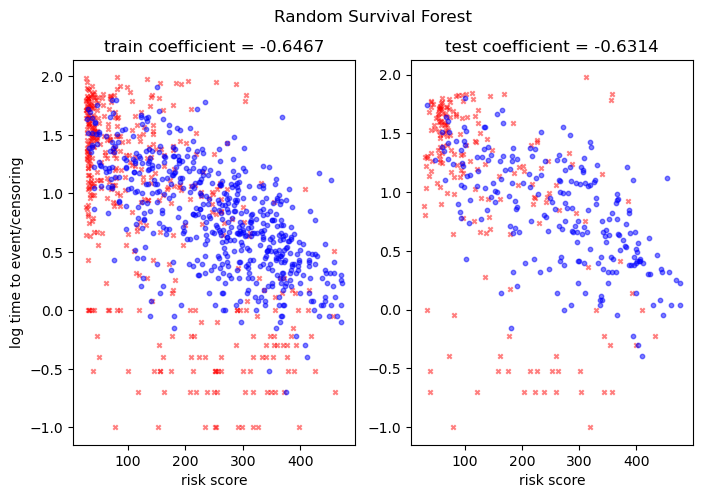

In [56]:
# plot the evaluation
zero_correction = 0.01
def plot_results(real, pred, ax, plot_tp=None):
    observed_t = [] # time to event
    observed_r = [] # risk score
    censored_t = [] # time to censor
    censored_r = [] # 
    for i in range(len(real)):
        if real[i][0] == True:
            observed_t.append(real[i][1])
            observed_r.append(pred[i])
            if real[i][1]==0:
                observed_t[-1] += zero_correction
        else:
            censored_t.append(real[i][1])
            censored_r.append(pred[i])
#     return observed_t, observed_r
    tp_lr = r_regression(np.log10([[i] for i in observed_t]), observed_r)
    
    ax.scatter(censored_r, np.log10(censored_t), marker="x", color="red", label="censored", s=10, alpha=0.5)
    ax.scatter(observed_r, np.log10(observed_t), marker="o", color="blue", label="observed", s=10, alpha=0.5)
    max_time = max(max(observed_t), max(censored_t))

    ax.set_xlabel("risk score")
    ax.set_title(plot_tp+" coefficient = {:.4f}".format(tp_lr[0]))
    
fig, axs = plt.subplots(1, 2, figsize=(8,5), dpi=100)
plot_results(train_y, rsf.predict(train_X), axs[0], "train")
plot_results(test_y, rsf.predict(test_X), axs[1], "test")
axs[0].set_ylabel("log time to event/censoring")
# axs[1].legend(bbox_to_anchor=(1.6,1))
tp_title = "Random Survival Forest"
plt.suptitle(tp_title)
plt.show()

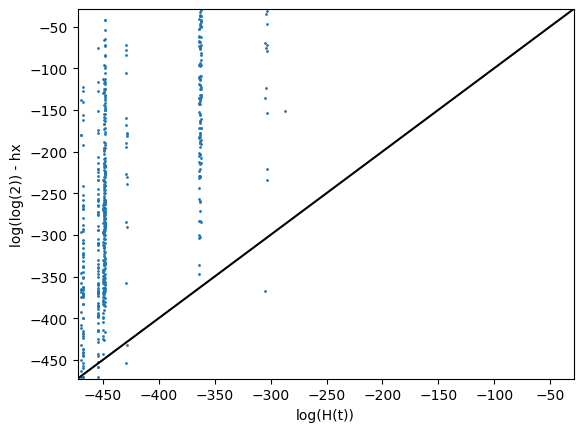

In [40]:
def get_xy_eval(train_y, risks):
    real_t = np.array([y[1] for y in train_y]) # a list of time
    real_s = np.array([y[0] for y in train_y]) # a list of event indicators, True for event and False for censoring
    time_unique = list(set(real_t))
    time_unique.sort()
    base_h0 = [[],[]]
    for i in range(len(time_unique)):
        tp_time = time_unique[i]
        tp_event = real_s[real_t==tp_time].sum()
        tp_domin = np.exp(risks[real_t>=tp_time]).sum()
        tp_h0 = tp_event / tp_domin
        base_h0[0].append(tp_time)
        base_h0[1].append(tp_h0)

    base_h0 = np.array(base_h0)
    cumu_h0 = np.cumsum(base_h0, axis=1)
    cumu_h0[0] = base_h0[0]
    hazard_dict = {int(cumu_h0[0][i]):cumu_h0[1][i] for i in range(len(cumu_h0[0]))}
    log_gT = []
    log2_minus_hx = []
    loglog2 = math.log(math.log(2))
    for i in range(len(train_y)):
        if train_y[i][0] == True: # if event happens
            tp_logT = math.log(hazard_dict[int(train_y[i][1])])
            tp_log2_minus_hx = loglog2 - risks[i]
            log_gT.append(tp_logT)
            log2_minus_hx.append(tp_log2_minus_hx)
            
    return log_gT, log2_minus_hx

log_gT, log2_minus_hx = get_xy_eval(train_y, rsf.predict(train_X))
plt.scatter(log_gT, log2_minus_hx, s=1)
val_min = min(min(log_gT), min(log2_minus_hx))
val_max = max(max(log_gT), max(log2_minus_hx))
plt.xlim(val_min, val_max)
plt.ylim(val_min, val_max)
plt.plot([val_min, val_max], [val_min, val_max], color="black")
plt.xlabel("log(H(t))")
plt.ylabel("log(log(2)) - hx")
plt.show()

In [37]:
log_gT[:5]

[-362.5675461294312,
 -362.4163151596768,
 -429.33575040677977,
 -448.47447606021797,
 -449.19830432428745]

In [39]:
log2_minus_hx[:5]

[-50.99685726529108,
 -122.72738376300795,
 -168.73578461818073,
 -97.44503254586506,
 -272.9451745792237]

In [82]:
inds_true = [i for i in range(len(train_y)) if train_y[i][0]==True]

risks = rsf.predict(np.array(train_X))
train_y_true = train_y[inds_true]
real_t = np.array([y[1] for y in train_y]) # a list of time
real_s = np.array([y[0] for y in train_y]) # a list of event indicators, True for event and False for censoring
time_unique = list(set(real_t))
time_unique.sort()
base_h0 = [[],[]]
for i in range(len(time_unique)):
    tp_time = time_unique[i]
    tp_event = real_s[real_t==tp_time].sum()
    tp_domin = risks[real_t>=tp_time].sum()
    tp_h0 = tp_event / tp_domin
    base_h0[0].append(tp_time)
    base_h0[1].append(tp_h0)

base_h0 = np.array(base_h0)
cumu_h0 = np.cumsum(base_h0, axis=1)
cumu_h0[0] = base_h0[0]
hazard_dict = {int(cumu_h0[0][i]):cumu_h0[1][i] for i in range(len(cumu_h0[0]))}
log_gT = []
log2_minus_hx = []
loglog2 = math.log(math.log(2))
for i in range(len(train_y)):
    if train_y[i][0] == True: # if event happens
        tp_logT = math.log(hazard_dict[int(train_y[i][1])])
        tp_log2_minus_hx = loglog2 - math.log(risks[i])
        log_gT.append(tp_logT)
        log2_minus_hx.append(tp_log2_minus_hx)

In [61]:
tp_event

1

In [49]:
train_y_true[:5]

array([( True, 33.5), ( True, 44.9), ( True, 13.4), ( True,  7.8),
       ( True,  4.2)], dtype=[('cens', '?'), ('time', '<f8')])

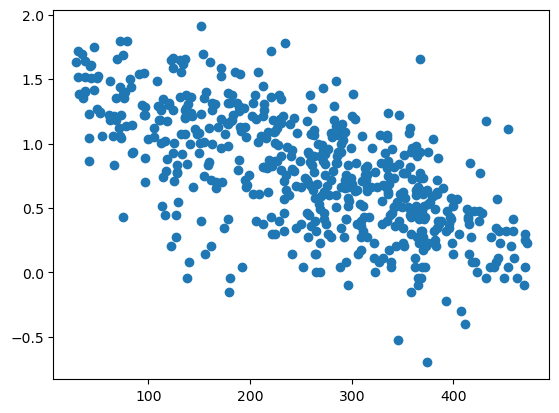

In [50]:
plt.scatter(risks, np.log10([y[1] for y in train_y_true]))

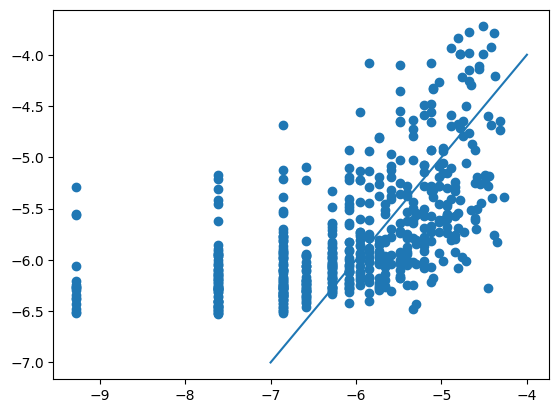

In [85]:
plt.scatter(log_gT, log2_minus_hx)
plt.plot([-7, -4], [-7, -4])

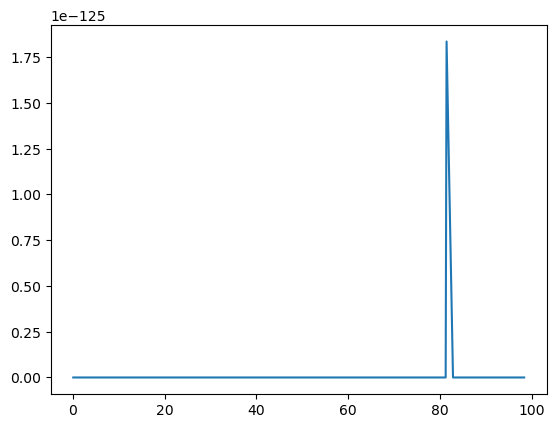

In [66]:
plt.plot(base_h0[0], base_h0[1])

In [69]:
base_h0[0][np.argmax(base_h0[1])]

81.4

In [71]:
np.argmax(base_h0[1])

364

In [70]:
real_s[real_t==81.4].sum()

1

In [74]:
base_h0[1][364]

1.8359427042098274e-125

In [77]:
np.exp(risks[real_t>=81.4]).sum()

5.44679307097653e+124

In [78]:
risks.max()

472.29008977970864

In [79]:
risks.min()

26.968546005453728